In [1]:
import numpy as np
import torch
from torch import nn
import LightPipes as lp
import matplotlib.pyplot as plt
import os, sys, h5py

from utils.functions import *
from utils.models.modalevaluator import ModalEvaluator


device = 'cuda:3'


truncate_circle = False

In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [3]:
n_zernike_rows=28

n_zernike_rows * (n_zernike_rows+1) // 2    

406

In [4]:
size = 21
decenter = [0,0]

n_zernike_rows=28

x = torch.linspace(-1,1,size)
y = torch.linspace(-1,1,size)

xx, yy = torch.meshgrid(x,y)


modes, mode_derivs = get_modes_and_derivs(decenter, xx, yy, n_zernike=n_zernike_rows, truncate_circle=False, pixel_basis = False)

vortex = modes[-1:]
zernikes = modes[:-1]

single_peak = torch.zeros_like(xx)[None]
single_peak[:,size//4,size//4] = 1


r = torch.sqrt(xx**2 + yy**2)
mask = (r>1)

vortex[:,mask] = 0
zernikes[:,mask] = 0

single_peak_coeffs = (single_peak * zernikes).sum((1,2))
coeffs = (vortex * zernikes).sum((1,2))

zernikes[:,mask] = np.nan
vortex[:,mask] = np.nan

row2coeffs = (coeffs[:3,None,None] * zernikes[:3]).sum(0)
row3coeffs = (coeffs[:6,None,None] * zernikes[:6]).sum(0)
row4coeffs = (coeffs[:15,None,None] * zernikes[:15]).sum(0)
row6coeffs = (coeffs[:21,None,None] * zernikes[:21]).sum(0)

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


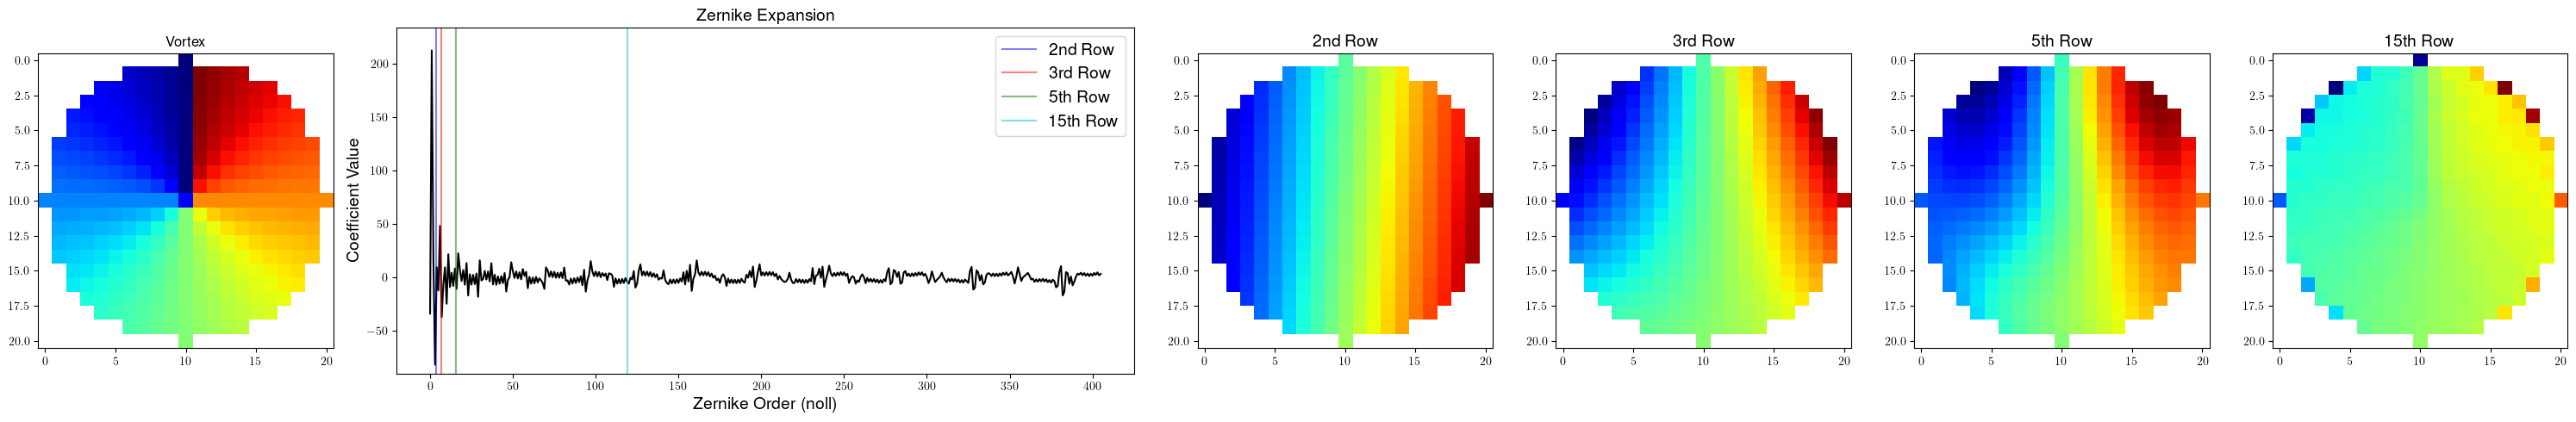

In [5]:
fig,ax = plt.subplots(1,6, figsize=(30,5), width_ratios=[1,2.5,1,1,1,1], )
ax[0].imshow(vortex[0],cmap='jet'); ax[0].set_title('Vortex')

ax[1].plot(coeffs, 'k'); ax[1].set_xlabel('Zernike Order (noll)', fontsize=14); ax[1].set_ylabel('Coefficient Value', fontsize=14); ax[1].set_title('Zernike Expansion', fontsize=14)

ax[1].plot(np.ones(10)*3.5, np.linspace(-1000000,1000000,10), 'b', alpha=.5, label='2nd Row')
ax[1].plot(np.ones(10)*6.5, np.linspace(-1000000,1000000,10), 'r', alpha=.5, label='3rd Row')
ax[1].plot(np.ones(10)*15.5, np.linspace(-1000000,1000000,10), 'g', alpha=.5, label='5th Row')
ax[1].plot(np.ones(10)*119, np.linspace(-1000000,1000000,10), 'c', alpha=.5, label='15th Row')
ax[1].legend(fontsize=14)

ax[1].set_ylim((coeffs.min()*1.1,coeffs.max()*1.1))

ax[2].imshow(row2coeffs,cmap='jet'); ax[2].set_title('2nd Row', fontsize=14)
ax[3].imshow(row3coeffs,cmap='jet'); ax[3].set_title('3rd Row', fontsize=14)
ax[4].imshow(row4coeffs,cmap='jet'); ax[4].set_title('5th Row', fontsize=14) 
# ax[5].imshow(row6coeffs,cmap='jet'); ax[5].set_title('6th Row', fontsize=14)
ax[5].imshow((coeffs[:,None,None] * zernikes[:]).sum(0),cmap='jet'); ax[5].set_title('15th Row', fontsize=14)
plt.tight_layout()

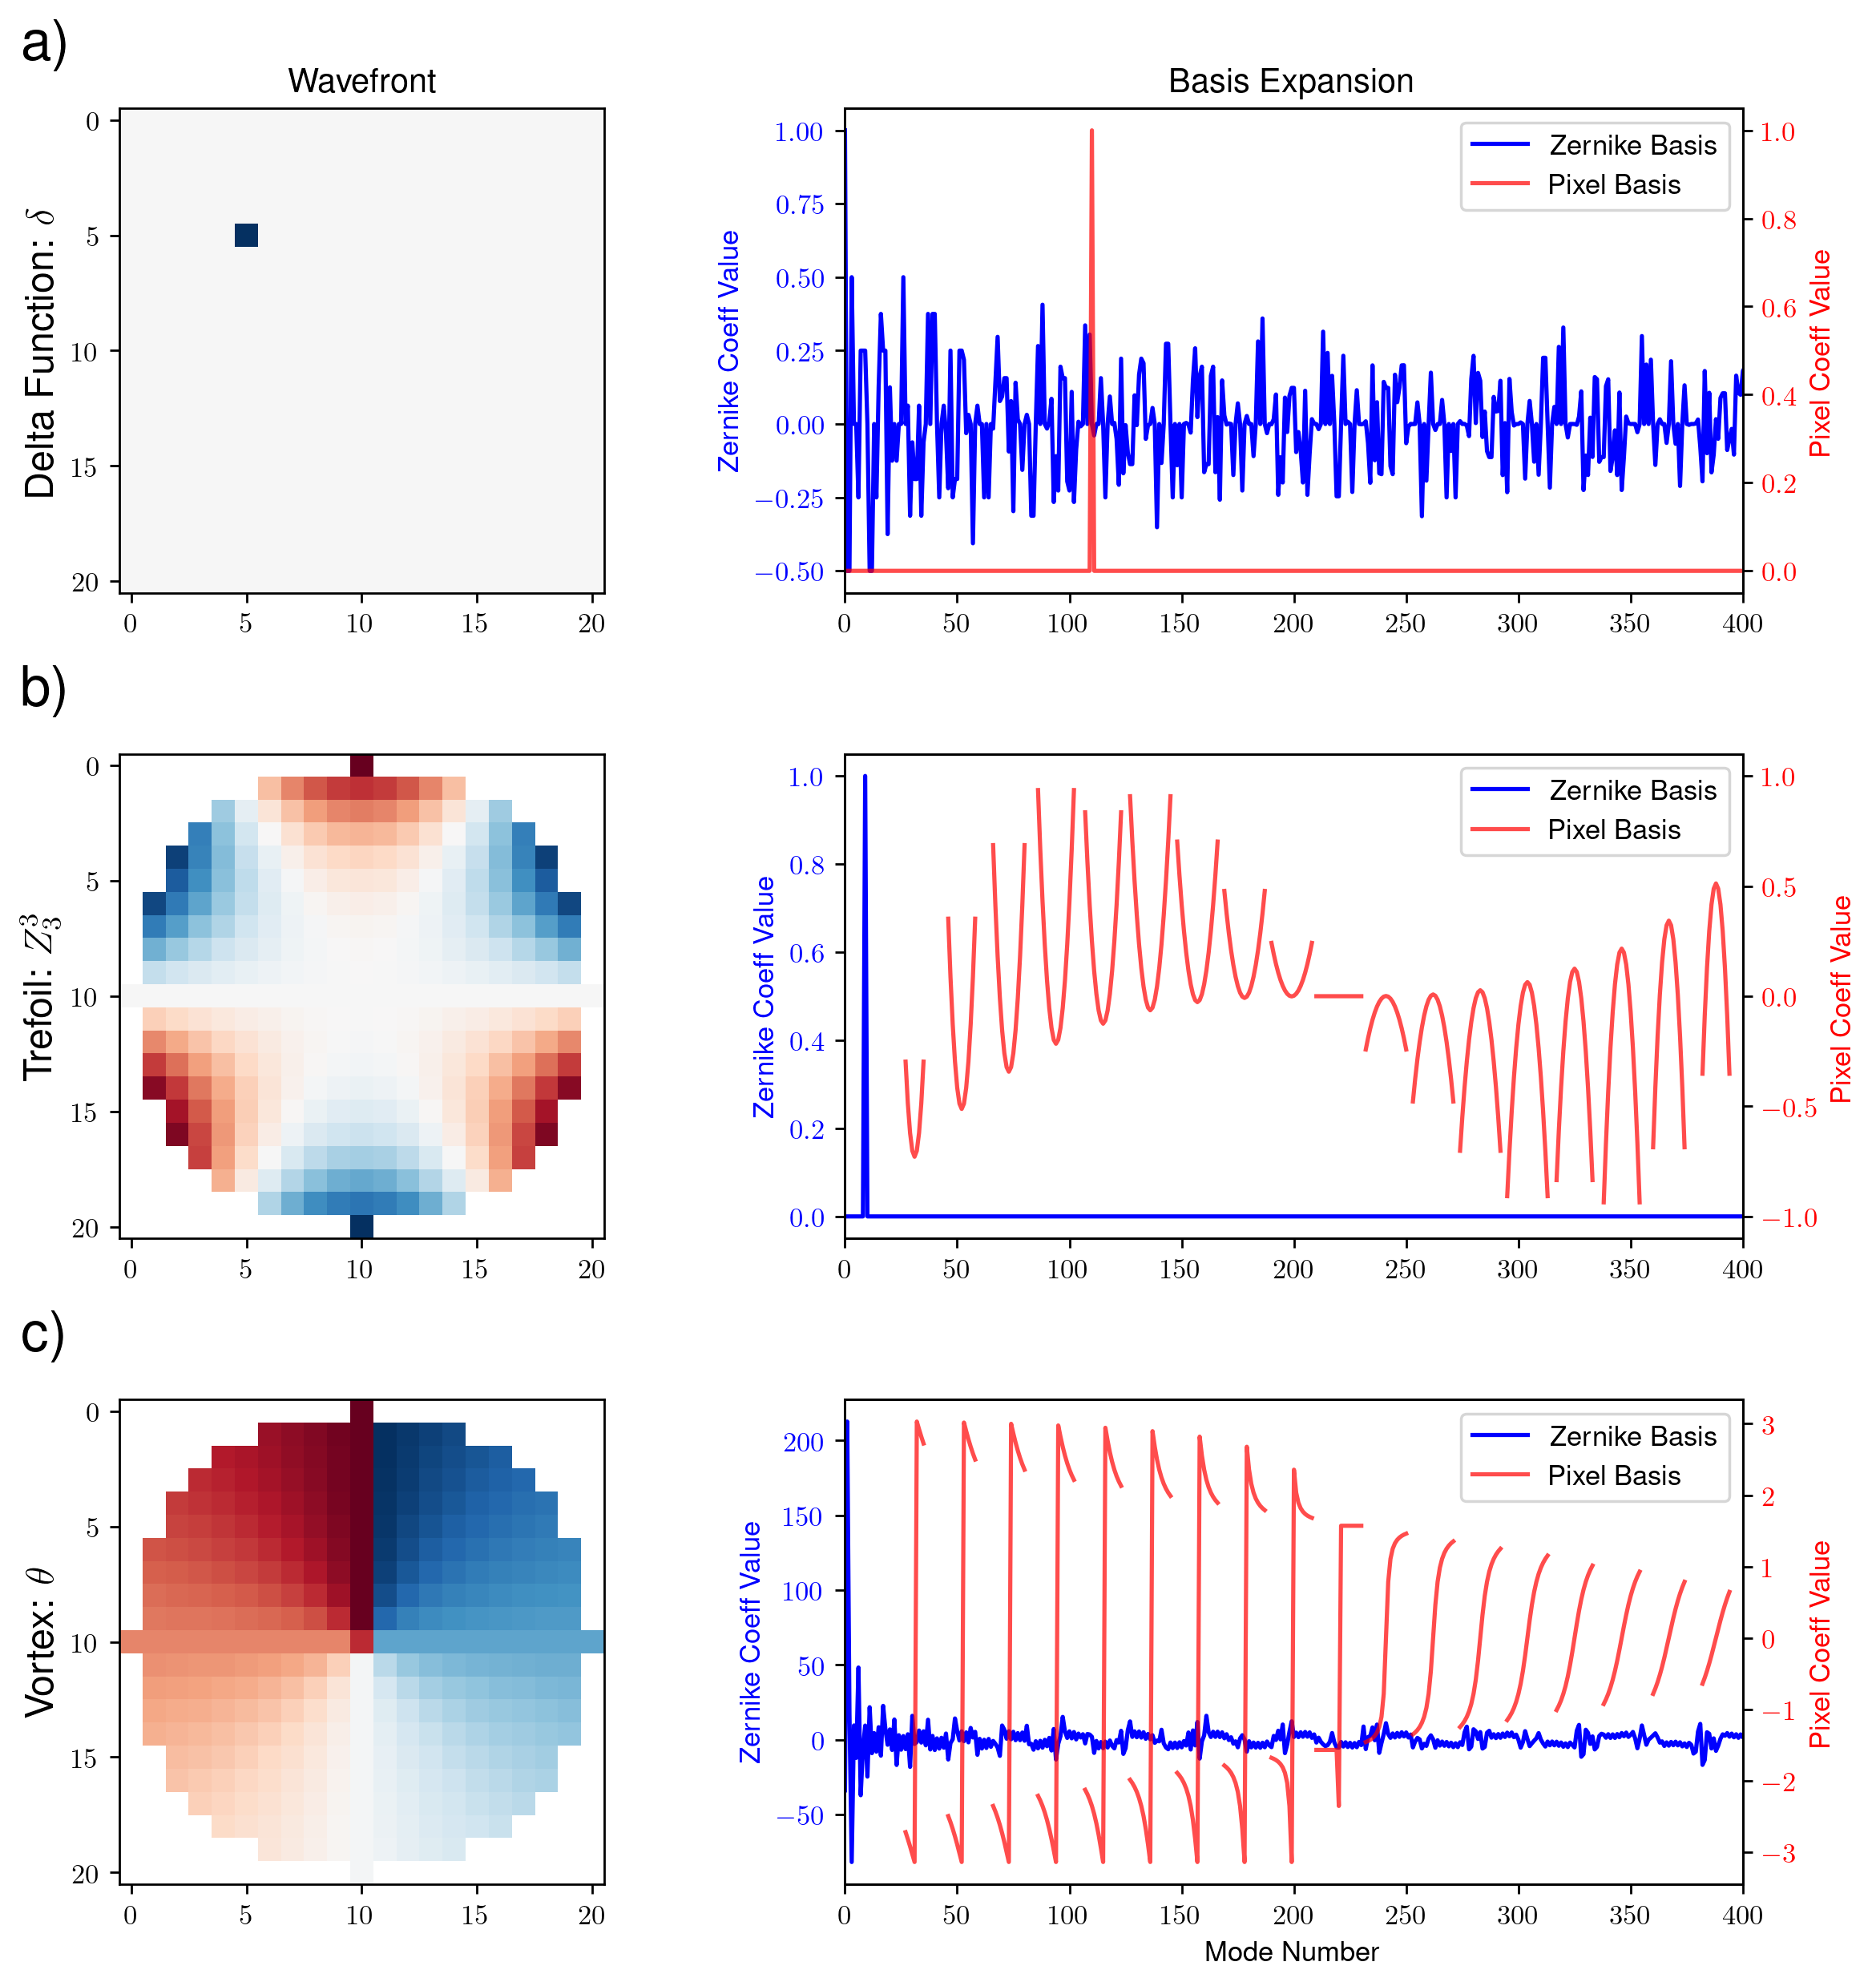

In [6]:
fig,ax = plt.subplots(3,2, figsize=(10,10), dpi=250)
ax[0,0].imshow(single_peak[0],cmap='RdBu', vmax=1, vmin=-1); ax[0,0].set_title('Wavefront'); ax[0,0].set_ylabel(r'Delta Function: $\delta$', fontsize=14)
ax[0,0].text(-0.2, 1.1, 'a)', transform=ax[0,0].transAxes, 
            size=20, weight='bold')
lns1= ax[0,1].plot(single_peak_coeffs, 'b',label='Zernike Basis'); ax[0,1].set_title('Basis Expansion')
ax[0,1].set_ylabel('Zernike Coeff Value', color='b')
ax[0,1].tick_params(axis='y', labelcolor='blue')
ax2 = ax[0,1].twinx() 
lns2 = ax2.plot(single_peak[0].flatten(), 'r', alpha=.7, label='Pixel Basis')

ax2.set_ylabel('Pixel Coeff Value', color='r')
ax2.tick_params(axis='y', labelcolor='r')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[0,1].legend(lns, labs, loc=0)
ax[0,1].set_xlim(0,400)

ax[1,0].imshow(zernikes[9],cmap='RdBu', vmax=1, vmin=-1);ax[1,0].set_ylabel(r'Trefoil: $Z_{3}^{3}$', fontsize=14)
ax[1,0].text(-0.2, 1.1, 'b)', transform=ax[1,0].transAxes, 
            size=20, weight='bold')

zernicoeff = np.zeros_like(coeffs)
zernicoeff[9] = 1
lns1= ax[1,1].plot(zernicoeff, 'b',label='Zernike Basis')
ax[1,1].set_ylabel('Zernike Coeff Value', color='b')
ax[1,1].tick_params(axis='y', labelcolor='blue')
ax2 = ax[1,1].twinx() 
lns2 = ax2.plot(zernikes[9].flatten(), 'r', alpha=.7, label='Pixel Basis')

ax2.set_ylabel('Pixel Coeff Value', color='r')
ax2.tick_params(axis='y', labelcolor='r')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[1,1].legend(lns, labs, loc=0)
ax[1,1].set_xlim(0,400)


ax[2,0].imshow(vortex[0],cmap='RdBu');ax[2,0].set_ylabel(r'Vortex: $\theta$', fontsize=14)
ax[2,0].text(-0.2, 1.1, 'c)', transform=ax[2,0].transAxes, 
            size=20, weight='bold')

lns1= ax[2,1].plot(coeffs, 'b',label='Zernike Basis')
ax[2,1].set_ylabel('Zernike Coeff Value', color='b')
ax[2,1].tick_params(axis='y', labelcolor='blue')
ax2 = ax[2,1].twinx() 
lns2 = ax2.plot(vortex.flatten(), 'r', alpha=.7, label='Pixel Basis')

ax2.set_ylabel('Pixel Coeff Value', color='r')
ax2.tick_params(axis='y', labelcolor='r')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax[2,1].legend(lns, labs, loc=0)

ax[2,1].set_xlim(0,400)
ax[2,1].set_xlabel('Mode Number')

plt.tight_layout()



